In [450]:
import pickle
with open('grand_teams.pkl', 'rb') as f:
    g_teams = pickle.load(f)

with open('test_bronze_teams.pkl', 'rb') as f:
    b_teams = pickle.load(f)


# Here we calculate the Jaccard and cosine similarties using the given data from the previous cell 

In [596]:
from typing import List
from data_types import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_CHECK = 10
NO_MATCH = -1



def find_jaccard(user1: dict, user2: dict):
    """
    Finds the Jaccard similarity between two given dictionaries
    """
    if len(user1) == 0 or len(user2) == 0:
        return 0
    items1 = set(user1.keys())
    items2 = set(user2.keys())
    return len(items1.intersection(items2)) / len(items1.union(items2))


def find_cosine(user1, user2):
    """
    Finds the cosine similarity between two given dictionaries
    """
    # If an item is not in user1 than their dot product will amount to zero anyways
    dot_prod = 0
    for item, rate in user1.items():
        if item in user2:
            dot_prod += rate * user2[item]
    size1 = 0
    for val in user1.values():
        size1 += val ** 2
    size2 = 0
    for val in user2.values():
        size2 += val ** 2
    if size1 * size2 == 0:
        return 0
    return dot_prod / ((size1 * size2) ** 0.5)


def get_sim_jac(user1: Team, user2: Team, length: int = BASE_CHECK):
    """
    Given a length, returns the average for the Jaccard similarity averaging
    """
    curr_jac = 0
    if len(user1.items) < length or len(user2.items) < length:
        return 0
    for i in range(1,length):
        curr_jac += find_jaccard(user1.items[i], user2.items[i])
    return curr_jac / (length-1)


def get_sim_cos(user1: Team, user2: Team, length: int = BASE_CHECK):
    """
    Given a length, returns the average for the cosine similarity averaging
    """
    curr_cos = 0
    if len(user1.items) < length or len(user2.items) < length:
        return 0
    for i in range(1,length):
        curr_cos += find_cosine(user1.items[i], user2.items[i])
    return curr_cos / (length-1)


def get_best_similar(curr_user: Team, users: List[Team], length: int = BASE_CHECK,
                     test_champion = False, champion_intersection = 0) -> [int]:
    """
    This function receives a list of processed_game_data from a single side and checks all the other users for their best matching
    :param length:
    :param curr_user: A team object to check for
    :param users: All the teams to check against
    :param test_champhion: If it is true it takes into account similiar champhions before comparing the users
    :return: A tuple with one the best Jaccard and the second being the cosine similarity
    """
    indices = [0]*2
    rankings_jaccard = []
    rankings_cosine = []
    for user2 in users:
        if test_champion:
            if len(curr_user.champions.intersection(user2.champions)) < champion_intersection:
                rankings_jaccard.append(NO_MATCH)
                rankings_cosine.append(NO_MATCH)
                continue
        rankings_jaccard.append(get_sim_jac(curr_user, user2, length))
        rankings_cosine.append(get_sim_cos(curr_user, user2, length))
    indices[0] = np.argmax(rankings_jaccard) if np.max(rankings_jaccard) != NO_MATCH else None
    indices[1] = np.argmax(rankings_cosine) if np.max(rankings_cosine) != NO_MATCH else None
    return indices


def check_grand_bronze_sim_correlation(b_teams, g_teams, test_champion = False,champhion_intersection = 0):
    """
    We check for best match according to the given metric and the given parameter.
    If test_champion = False the function runs all 3 times and checks for
    both metric and for every time it calculates the initial similarity and returns a predicition for the closest
    strategy. After that it checks for the rest of the game and looks if the strategy was actually close.
    If test_champion = True, only checks for the inital 10 minutes of the game and takes into account 
    if the champions of the two given games to check have an intersections.
    """
    final_res = {}
    time_tests = [5,10,15] if not test_champion else [10]
    for timeCheck in time_tests:
        win = []
        jac = []
        cos = []
        for i, test in enumerate(b_teams):
            best_grand_jaccard, best_grand_cosine = get_best_similar(test, g_teams,timeCheck, test_champion, champhion_intersection)
            if best_grand_jaccard != None:
                best_jaccard_full_sim = get_sim_jac(test, g_teams[best_grand_jaccard],
                                                    min(len(test.items),len(g_teams[best_grand_jaccard].items)))
            else:
                best_jaccard_full_sim = np.nan
            if best_grand_cosine:
                best_cosine_full_sim = get_sim_cos(test, g_teams[best_grand_cosine],
                                                   min(len(test.items),len(g_teams[best_grand_cosine].items)))
            else:
                best_cosine_full_sim = np.nan

            cos.append(best_cosine_full_sim)
            jac.append(best_jaccard_full_sim)
            win.append(test.winners)
                
        final_res[timeCheck] = pd.DataFrame({"win": win,"jac":jac,"cos":cos})
    return final_res



In [453]:
allTimes = check_grand_bronze_sim_correlation(b_teams, g_teams)
print("Done with allTimes")
champion_1 = check_grand_bronze_sim_correlation(b_teams, g_teams, test_champion= True, champhion_intersection=1)
print("Done with champ 1")
champion_2 = check_grand_bronze_sim_correlation(b_teams, g_teams, test_champion= True, champhion_intersection=2)
print("Done with champ 2")
champion_3 = check_grand_bronze_sim_correlation(b_teams, g_teams, test_champion= True, champhion_intersection=3)
print("Done with champ 3")
champion_1 = champion_1[10]
champion_2 = champion_2[10]
champion_3 = champion_3[10]



Done with allTimes
Done with allTimes 1
Done with allTimes 2
Done with allTimes 3


In [456]:
#From the code we know that if we didnt find any possible matches we added a np.nan. Here we drop all the teams 
#which we couldent find a bronze team to check for
print("With 1 champion matching we had to drop:", champion_1.cos.isna().sum())
print("With 2 champion matching we had to drop:", champion_2.cos.isna().sum())
print("With 3 champion matching we had to drop:", champion_3.cos.isna().sum())
champion_1.dropna(inplace = True)
champion_2.dropna(inplace = True)
champion_3.dropna(inplace = True)

With 1 champion matching we had to drop: 0
With 2 champion matching we had to drop: 0
With 3 champion matching we had to drop: 311


In [471]:
allData = {"Data when taking 5 minutes of the game to check similarty" : allTimes[5],
          "Data when taking 10 minutes of the game to check similarty" : allTimes[10],
          "Data when taking 15 minutes of the game to check similarty" : allTimes[15],
          "Data when taking 10 minutes and restricting for at least 1 common champion" : champion_1,
          "Data when taking 10 minutes and restricting for at least 2 common champion" : champion_2,
          "Data when taking 10 minutes and restricting for at least 3 common champion" : champion_3}

# After getting the data we need to mask it for bins

In [472]:
#This function will take a datafrane with 3 columns, for win, Jaccard, cosine ans create 2 new columns that
#will have the bins from 1-10
def maskBins(ans):
    qunt = np.linspace(0,1,10)
    passQunt = 0
    for i,q in enumerate(qunt):
        currQunt = ans["cos"].quantile(q)
        ans.loc[(passQunt<=ans.cos) & (ans.cos<=currQunt),"cosGrade"] = i
        passQunt = currQunt

    passQunt = 0
    for i,q in enumerate(qunt):
        currQunt = ans["jac"].quantile(q)
        ans.loc[(passQunt<=ans.jac) & (ans.jac<=currQunt),"jacGrade"] = i
        passQunt = currQunt
for df in allData.values():
    maskBins(df)

1
1
1
1
1
1


# Plotting the data

In [591]:
from matplotlib import pyplot as plt
import scipy.stats

#some example data
def plot_confidence_interval(x,y, ci, color ,name,alpha = 0.05, horizontal_line_width=0.1):
    confidence_interval = scipy.stats.norm.ppf(1 - alpha/2)*ci
    left = x - horizontal_line_width / 2
    top = y - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = y + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, y, 'o', color=color)
    plt.ylim([0.2,0.8])
    plt.title(name)
    plt.savefig(name)
    

def plot_with_ci(points, color,name):
    for i,point in points.iterrows():
        plot_confidence_interval(i,point[0],point[1],color,name)

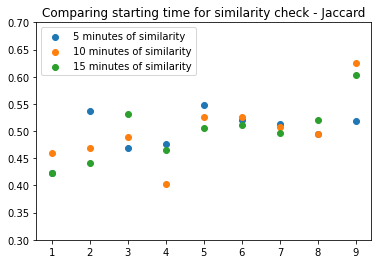

In [581]:
#In order to plot more easy
data_labels = ["5 minutes of similarity", "10 minutes of similarity", "15 minutes of similarity",
              "At least 1 common champion","At least 2 common champion","At least 3 common champion"]

#Plotting by time
res5_jac = pd.DataFrame()
res5_jac["win_rate"] = allTimes[5][["win","jacGrade"]].groupby("jacGrade").mean()
res10_jac = pd.DataFrame()
res10_jac["win_rate"] = allTimes[10][["win","jacGrade"]].groupby("jacGrade").mean()
res15_jac = pd.DataFrame()
res15_jac["win_rate"] = allTimes[15][["win","jacGrade"]].groupby("jacGrade").mean()

plt.scatter(res5_jac.index,res5_jac.win_rate, label = data_labels[0])
plt.scatter(res10.index,res10_jac.win_rate, label = data_labels[1])
plt.scatter(res15.index,res15_jac.win_rate, label = data_labels[2])
plt.title("Comparing starting time for similarity check - Jaccard")
plt.ylim([0.3,0.7])
plt.legend()
plt.savefig("Comparing starting time for similarity check - Jaccard")

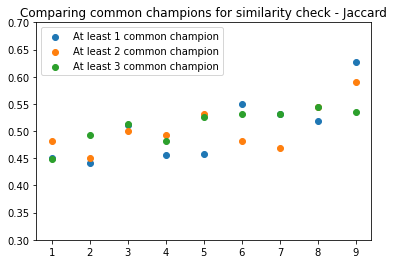

In [582]:
#Plotting by champions
champ1_jac = pd.DataFrame()
champ1_jac["win_rate"] = champion_1[["win","jacGrade"]].groupby("jacGrade").mean()
champ2_jac = pd.DataFrame()
champ2_jac["win_rate"] = champion_2[["win","jacGrade"]].groupby("jacGrade").mean()
champ3_jac = pd.DataFrame()
champ3_jac["win_rate"] = champion_3[["win","jacGrade"]].groupby("jacGrade").mean()

plt.scatter(champ1_jac.index,champ1_jac.win_rate, label = data_labels[3])
plt.scatter(champ2_jac.index,champ2_jac.win_rate, label = data_labels[4])
plt.scatter(champ3_jac.index,champ3_jac.win_rate, label = data_labels[5])
plt.title("Comparing common champions for similarity check - Jaccard")
plt.ylim([0.3,0.7])
plt.legend()
plt.savefig("Comparing common champions for similarity check - Jaccard")

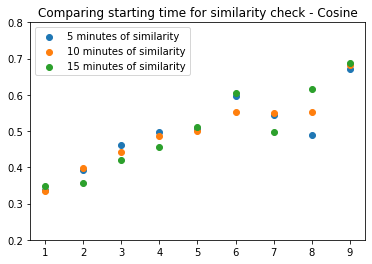

In [583]:
#Plotting by time
res5_cos = pd.DataFrame()
res5_cos["win_rate"] = allTimes[5][["win","cosGrade"]].groupby("cosGrade").mean()
res10_cos = pd.DataFrame()
res10_cos["win_rate"] = allTimes[10][["win","cosGrade"]].groupby("cosGrade").mean()
res15_cos = pd.DataFrame()
res15_cos["win_rate"] = allTimes[15][["win","cosGrade"]].groupby("cosGrade").mean()

plt.scatter(res5_cos.index,res5_cos.win_rate, label = data_labels[0])
plt.scatter(res10_cos.index,res10_cos.win_rate, label = data_labels[1])
plt.scatter(res15_cos.index,res15_cos.win_rate, label = data_labels[2])
plt.title("Comparing starting time for similarity check - Cosine")
plt.ylim([0.2,0.8])
plt.legend()
plt.savefig("Comparing starting time for similarity check - cosine")

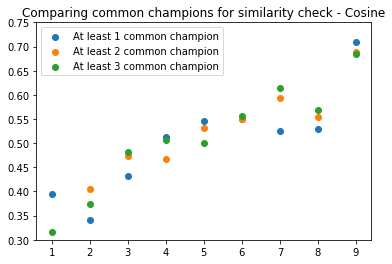

In [584]:
#Plotting by champions
champ1_cos = pd.DataFrame()
champ1_cos["win_rate"] = champion_1[["win","cosGrade"]].groupby("cosGrade").mean()
champ2_cos = pd.DataFrame()
champ2_cos["win_rate"] = champion_2[["win","cosGrade"]].groupby("cosGrade").mean()
champ3_cos = pd.DataFrame()
champ3_cos["win_rate"] = champion_3[["win","cosGrade"]].groupby("cosGrade").mean()

plt.scatter(champ1_cos.index,champ1_cos.win_rate, label = data_labels[3])
plt.scatter(champ2_cos.index,champ2_cos.win_rate, label = data_labels[4])
plt.scatter(champ3_cos.index,champ3_cos.win_rate, label = data_labels[5])
plt.title("Comparing common champions for similarity check - Cosine")
plt.ylim([0.3,0.75])
plt.legend()
plt.savefig("Comparing common champions for similarity check - Cosine")

### Looking at the graphs we see that there isn't much diffrence between the champion parameter but so we will try to look at the extreme, which is 3

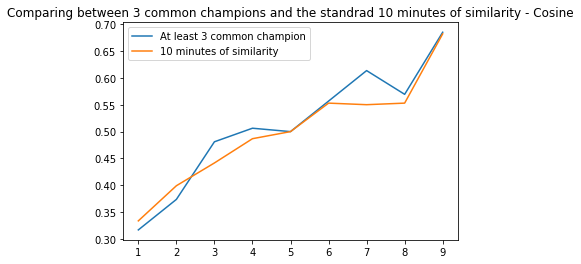

In [585]:

plt.plot(champ3_cos.index,champ3_cos.win_rate, label = data_labels[5])
plt.plot(res10_cos.index,res10_cos.win_rate, label = data_labels[1])
title_cos = "Comparing between 3 common champions and the standrad 10 minutes of similarity - Cosine"
plt.title(title_cos)
plt.legend()
plt.savefig(title_cos)



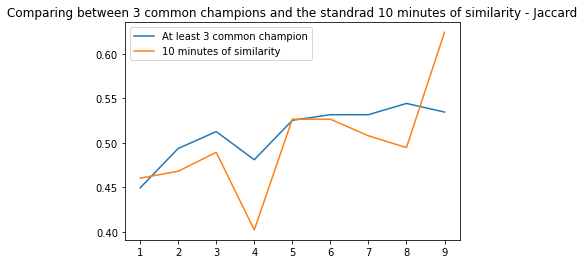

In [586]:
plt.plot(champ3_jac.index,champ3_jac.win_rate, label = data_labels[5])
plt.plot(res10_jac.index,res10_jac.win_rate, label = data_labels[1])
title_jac = "Comparing between 3 common champions and the standrad 10 minutes of similarity - Jaccard"
plt.title(title_jac)
plt.legend()
plt.savefig(title_jac)


### Lets compare between the win rate for the jaccard and the cosine


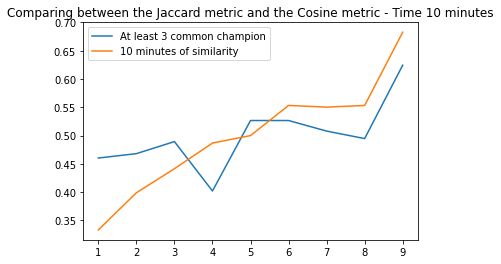

In [587]:
plt.plot(res10_jac.index,res10_jac.win_rate, label = data_labels[5])
plt.plot(res10_cos.index,res10_cos.win_rate, label = data_labels[1])
title_time = "Comparing between the Jaccard metric and the Cosine metric - Time 10 minutes"
plt.title(title_time)
plt.legend()
plt.savefig(title_time)



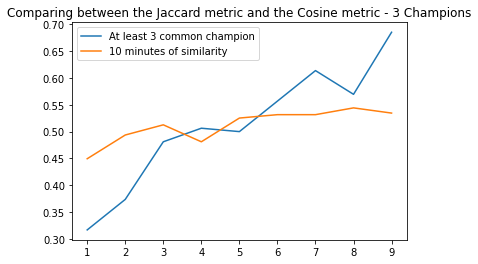

In [588]:
plt.plot(champ3_cos.index,champ3_cos.win_rate, label = data_labels[5])
plt.plot(champ3_jac.index,champ3_jac.win_rate, label = data_labels[1])
title_champ = "Comparing between the Jaccard metric and the Cosine metric - 3 Champions"
plt.title(title_champ)
plt.legend()
plt.savefig(title_champ)


### After plotting the data with our choosen parametrs in mind, we see that there the cosine metric seems better. Hence we will now try to take into account only the cosine metric and now will add CI

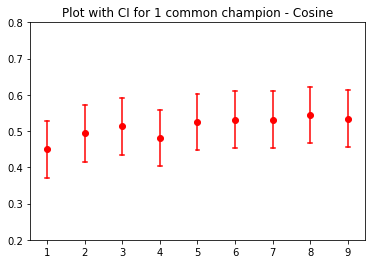

In [592]:
champ_ci_1 = champion_1[["win","jacGrade"]].groupby("jacGrade").mean()
champ_ci_1["ci"] = ((champ_ci_jac["win"]*(1-champ_ci_jac["win"]))/champion_1[["win","jacGrade"]].groupby("jacGrade").count()["win"])**0.5
plot_with_ci(champ_ci_jac,"r","Plot with CI for 1 common champion - Cosine")



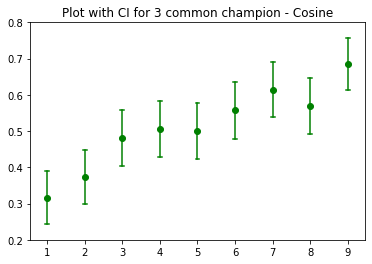

In [593]:
champ_ci_3 = champion_3[["win","cosGrade"]].groupby("cosGrade").mean()
champ_ci_3["ci"] = ((champ_ci_cos["win"]*(1-champ_ci_cos["win"]))/champion_3[["win","cosGrade"]].groupby("cosGrade").count()["win"])**0.5
plot_with_ci(champ_ci_cos,"g","Plot with CI for 3 common champion - Cosine")


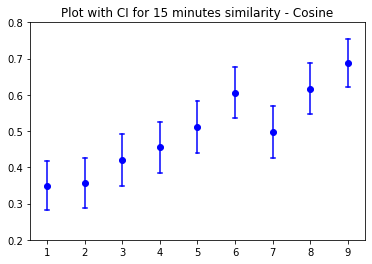

In [594]:
time_ci_15 = allTimes[15][["win","cosGrade"]].groupby("cosGrade").mean()
time_ci_15["ci"] = ((time_ci_15["win"]*(1-time_ci_15["win"]))/allTimes[15][["win","cosGrade"]].groupby("cosGrade").count()["win"])**0.5
plot_with_ci(time_ci_15,"b","Plot with CI for 15 minutes similarity - Cosine")

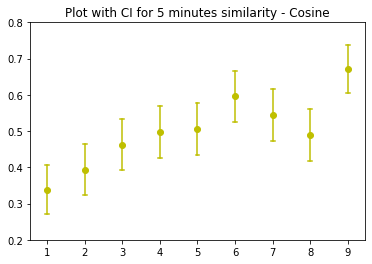

In [595]:
time_ci_5 = allTimes[5][["win","cosGrade"]].groupby("cosGrade").mean()
time_ci_5["ci"] = ((time_ci_5["win"]*(1-time_ci_5["win"]))/allTimes[5][["win","cosGrade"]].groupby("cosGrade").count()["win"])**0.5
plot_with_ci(time_ci_5,"y","Plot with CI for 5 minutes similarity - Cosine")